In [7]:
import os
import glob

import cv2
import json
import fiona

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import time
from tqdm import tqdm
from collections import defaultdict
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision import datasets, models, transforms, models
import segmentation_models_pytorch as smp


from PIL import Image
from albumentations.pytorch import ToTensorV2

import albumentations
import albumentations.augmentations as A

sns.set(font_scale=1.3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
class EyeDataset(Dataset):
    def __init__(self, images, masks, distances, transforms=None):
        self.images = images
        self.masks = masks
        self.distances = distances
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        distance = self.distances[idx]
        
        if self.transforms is not None:
            sample = self.transforms(image=image, masks=[mask, distance])
            image, mask, distance = sample['image'], sample['masks'][0], sample['masks'][1]
        
        image = (image / 255).astype(np.float32)
        distance = torch.tensor(distance)
        
        image, mask = torch.tensor(image).permute(2, 0, 1), torch.tensor(mask)
        return image, mask, distance

In [3]:
transforms = albumentations.Compose([
    A.geometric.transforms.Affine(rotate=(-60, 60), scale=(0.8, 1), p=0.5),
    A.geometric.transforms.VerticalFlip(p=0.5),
    A.geometric.transforms.HorizontalFlip(p=0.5),
])

In [4]:
distances = np.load('distances.npy').astype(np.float32)
images = np.load('images.npy').astype(np.uint8)
masks = np.load('masks.npy').astype(np.uint8)

In [5]:
data_size = len(glob.glob(f'./data_transformed/train/image_*.png'))
idx = np.arange(data_size)

train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42)

train_images, val_images = images[train_idx], images[val_idx]
train_masks, val_masks = masks[train_idx], masks[val_idx]
train_distances, val_distances = distances[train_idx], distances[val_idx]

del images, masks, distances

In [6]:
train_dataset = EyeDataset(train_images, train_masks, train_distances, transforms)
val_dataset = EyeDataset(val_images, val_masks, val_distances)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

del train_images, val_images
del train_masks, val_masks
del train_distances, val_distances

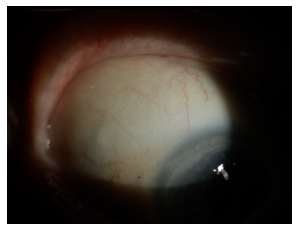

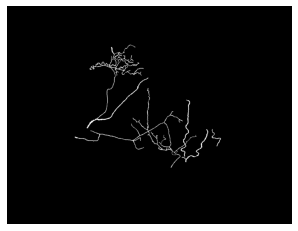

In [8]:
i = 232

plt.imshow((train_dataset[i][0].permute(1, 2, 0) * 255).numpy().astype(np.uint8))
plt.axis('off')
plt.show()

plt.imshow((train_dataset[i][1].numpy() * 255).astype(np.uint8), cmap='gray')
plt.axis('off')
plt.show()

In [9]:
def dice_coef(y_pred, y_true, smooth = 1e-8):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = (y_true_f * y_pred_f).sum()
    return (2. * intersection + smooth) / ((y_true_f).sum() + (y_pred_f).sum() + smooth)


class SoftDice:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon

    def __call__(self, predictions, targets):
        numerator = torch.sum(2 * predictions * targets)
        denominator = torch.sum(predictions + targets)
        return numerator / (denominator + self.epsilon)


def make_criterion():
    soft_dice = SoftDice()

    def exp_dice(pred, target):
        return 1 - soft_dice(pred, target)
    
    def boundary_loss(y_pred, y_true_dist_map):
        multipled = y_pred * y_true_dist_map
        return multipled.mean()
    
    def combined_loss(y_pred, target, y_true_dist_map):
        return exp_dice(y_pred, target) + 0.01 * boundary_loss(y_pred, y_true_dist_map)

    return exp_dice

In [10]:
num_epochs = 10

model = smp.Unet(  
    encoder_name='resnet50',
    encoder_weights='imagenet', 
    in_channels=3,
    classes=1,
    activation='sigmoid'
).to(device)

criterion = make_criterion()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [13]:
model.load_state_dict(torch.load('model_56.3_1.pth'));

In [72]:
threshold = 0.5
results = defaultdict(list)
model.eval()
with torch.no_grad():
    for image, mask, distance in tqdm(val_dataloader):
        image, mask, distance = image.to(device), mask.to(device), distance.to(device)
        output = model(image).squeeze(1)
        
        results['output'].append(output.detach().cpu())
        results['target'].append(mask.cpu())

        del output
        del mask
        del distance

output, mask = (torch.cat(results['output']) > threshold).numpy() * 1, torch.cat(results['target']).numpy()
del results

100%|████████████████████████████████████████████████████████████████████████████████| 131/131 [00:14<00:00,  9.19it/s]


epoch number: 2
time per epoch: 200.12s
val epoch dice: 0.62


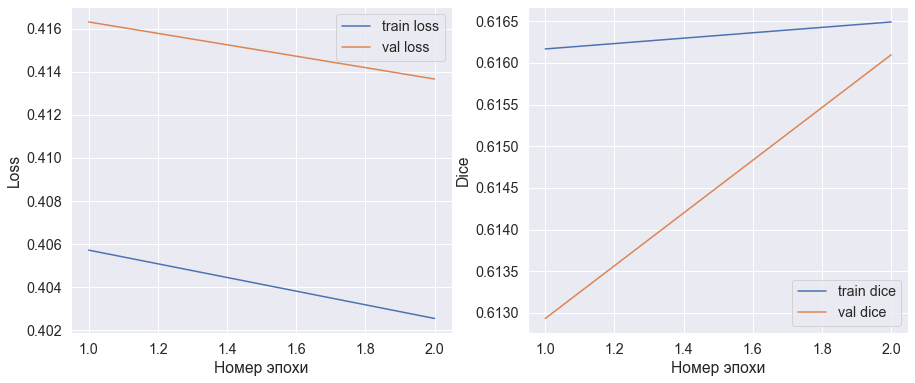

In [18]:
history = defaultdict(list)
threshold = 0.5
for epoch in range(2):
    start = time.time()
    
    results = defaultdict(list)
    model.train()
    for image, mask, distance in tqdm(train_dataloader):
        image, mask, distance = image.to(device), mask.to(device), distance.to(device)
        
        optimizer.zero_grad()
        output = model(image).squeeze(1)
        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()
        
        results['loss'].append(loss.item())
        results['output'].append(output.detach().cpu())
        results['target'].append(mask.cpu())
        
        del loss
        del output
        del mask
        del distance
    
    history['train_loss'].append(np.mean(results['loss']))
    output, mask = (torch.cat(results['output']) > threshold) * 1, torch.cat(results['target'])
    del results
    history['train_dice'].append(dice_coef(output, mask).item())
    
    results = defaultdict(list)
    model.eval()
    with torch.no_grad():
        for image, mask, distance in tqdm(val_dataloader):
            image, mask, distance = image.to(device), mask.to(device), distance.to(device)
            output = model(image).squeeze(1)
            loss = criterion(output, mask)
            
            results['loss'].append(loss.item())
            results['output'].append(output.detach().cpu())
            results['target'].append(mask.cpu())
            
            del loss
            del output
            del mask
            del distance

    history['val_loss'].append(np.mean(results['loss']))
    output, mask = (torch.cat(results['output']) > threshold) * 1, torch.cat(results['target'])
    del results
    history['val_dice'].append(dice_coef(output, mask).item())
    end = time.time()

    clear_output()
    print('epoch number: {}'.format(epoch + 1))
    print('time per epoch: {}s'.format(round(end - start, 2)))
    print('val epoch dice: {}'.format(round(history['val_dice'][-1], 2)))
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(epoch + 1) + 1, history['train_loss'], label='train loss')
    plt.plot(np.arange(epoch + 1) + 1, history['val_loss'], label='val loss')
    plt.xlabel('Номер эпохи')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(epoch + 1) + 1, history['train_dice'], label='train dice')
    plt.plot(np.arange(epoch + 1) + 1, history['val_dice'], label='val dice')
    plt.xlabel('Номер эпохи')
    plt.ylabel('Dice')
    plt.legend()
    
    plt.show()

In [19]:
# torch.save(model.state_dict(), 'model_56.6.pth')
# torch.save(model.state_dict(), 'model_hz_1.pth')
# torch.save(model.state_dict(), 'model_hz_2.pth')
# torch.save(model.state_dict(), 'model_hz_3.pth')
# torch.save(model.state_dict(), 'model_hz_4.pth')
# torch.save(model.state_dict(), 'model_hz_6.pth')
# torch.save(model.state_dict(), 'model_hz_7.pth')
# torch.save(model.state_dict(), 'model_hz_8.pth')

In [61]:
test_transforms = ToTensorV2(transpose_mask=True)

In [65]:
models = [
    smp.Unet(  
        encoder_name='resnet50',
        encoder_weights='imagenet', 
        in_channels=3,
        classes=1,
        activation='sigmoid'
    ).to(device),
    smp.Unet(  
        encoder_name='resnet50',
        encoder_weights='imagenet', 
        in_channels=3,
        classes=1,
        activation='sigmoid'
    ).to(device),
    smp.Unet(  
        encoder_name='resnet101',
        encoder_weights='imagenet', 
        in_channels=3,
        classes=1,
        activation='sigmoid'
    ).to(device),
        smp.Unet(  
        encoder_name='resnet34',
        encoder_weights='imagenet', 
        in_channels=3,
        classes=1,
        activation='sigmoid'
    ).to(device),
        smp.Unet(  
        encoder_name='resnet50',
        encoder_weights='imagenet', 
        in_channels=3,
        classes=1,
        activation='sigmoid'
    ).to(device)
]

paths = [
    'model_56.3_1.pth', 'model_56.6_2.pth', 'model_56.7_3.pth', 'model_56.0_4.pth', 'model_56.0_5.pth',
]

for path, model in zip(paths, models):
    model.load_state_dict(torch.load(path))

In [66]:
image_paths = glob.glob('./data/test/*')
for image_path in tqdm(image_paths):
    image = cv2.imread(image_path)
    H, W, C = image.shape
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image / 255, dtype=np.float32)
    image = np.concatenate((image, np.zeros((16, W, C))), axis=0)
    image = np.concatenate((image, np.zeros((H + 16, 8, C))), axis=1).astype(np.float32)
    image = test_transforms(image=image)['image']
    
    predictions = []
    for model in models:
        predict = model.eval()(image[None].to('cuda'))[0, 0].detach().cpu().numpy()[:H, :W]
        predict = ((predict > 0.01) * 255).astype(np.uint8)
        # predict = ((cv2.resize(predict, image_shape[::-1]) > 0.5) * 255).astype(np.uint8)
        predictions.append(predict)
    
    predict = np.stack(predictions)
    predict = np.argmax(np.stack(((predict == 0).sum(axis=0), (predict == 255).sum(axis=0))), axis=0)
    predict = (predict * 255).astype(np.uint8)
    
    predict = Image.fromarray(predict)
    predict.save(f'./submission_stacked/{image_path.split(os.sep)[-1]}')

100%|████████████████████████████████████████████████████████████████████████████████| 301/301 [02:50<00:00,  1.77it/s]
